# Sources:
- https://www.kaggle.com/code/aylinnaebzadeh/ufo-project-part-2/edit#Load-Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ufo-sightings/complete.csv
/kaggle/input/ufo-sightings/scrubbed.csv
/kaggle/input/ufo-data-scrubbed-preprocessed/ufo_data_scrubbed_preprocessed.csv


# Install Libraries and Modules

In [2]:
!pip install text2emotion

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.0 MB/s eta 0:00:00


In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Import Libraries and Modules

In [5]:
import pandas as pd #data manipulation
import numpy as np #numerical computing
import csv 
import datetime 
import geopandas as gpd 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from shapely.geometry import Point
import seaborn as sns # create statistical plots: line plot, kde plot, heatmap, violin plot, bar plot
from wordcloud import WordCloud
import matplotlib.colors as mcolors #to create cropped colourmap
from matplotlib.colors import ListedColormap #to create colormap for shapes vs sentiment bar plot
from tqdm import tqdm
import plotly.express as px #Interactive over time
from geopy.exc import GeopyError #For filling in na countries
from geopy.geocoders import Nominatim

import nltk #for text analysis (natural language tool kit)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.tag import pos_tag
import text2emotion as te
import emoji 
from spacy.cli import download #for emotion

from PIL import Image #for wordcloud mask

from sklearn.cluster import DBSCAN #for cluster analysis
from sklearn.cluster import KMeans #world map k means clustering

from collections import Counter #for 10 words and sentimetns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [6]:
ufo_data = pd.read_csv("/kaggle/input/ufo-data-scrubbed-preprocessed/ufo_data_scrubbed_preprocessed.csv")

In [7]:
ufo_data.head()

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year
0,0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949
1,1,1949-10-10 21:00:00,lackland afb,tx,Unknown,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949
2,2,1955-10-10 17:00:00,chester (uk/england),Unknown,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955
3,3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956
4,4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960


In [9]:
print(ufo_data['country'].value_counts())

country
us         65114
Unknown     9670
ca          3000
gb          1905
au           538
de           105
Name: count, dtype: int64


# Text Analysis

Create a deep copy from initial dataframe

In [8]:
ufo_data_text = ufo_data.copy()

In [11]:
ufo_data_text.head()

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year
0,0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949
1,1,1949-10-10 21:00:00,lackland afb,tx,Unknown,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949
2,2,1955-10-10 17:00:00,chester (uk/england),Unknown,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955
3,3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956
4,4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960


In [9]:
tqdm.pandas()

In [10]:
def tokenize_comments(comment):
    '''This function tokenizes a comment by splitting it into individual words and converting them to lowercase and removes 
    duplicates. (Tokenizes using word_tokenize from the NLTK library)

    :param comment: A string containing the comment to be tokenized.
    :return: A list of unique tokens extracted from the comment.
    '''
    try:
        return list(set(word_tokenize(comment.lower())))
    except:
        return []

In [11]:
#Create a new column containing the tokenized comment 
ufo_data_text['tokenized comments'] = ufo_data_text['comments'].progress_apply(tokenize_comments)

100%|██████████| 80332/80332 [00:19<00:00, 4218.10it/s]


In [18]:
ufo_data_text['tokenized comments'][:5]

0    [fall, 1949-50., scout, occurred, early, boy, ...
1    [&, lackland, lights, dime, #, across, tx, afb...
2    [england, &, 44, chester, circular, green/oran...
3    [pm, &, about, had, leaving, we, home, were, m...
4    [&, 39, quot, as, night, #, flying, exercise, ...
Name: tokenized comments, dtype: object

In [12]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokenized):
    '''This function takes a list of tokens and removes stopwords using a predefined set of stopwords (stop_words from above)

    :param tokenized: A list of tokens from which stopwords are to be removed.
    :return: A list of tokens with stopwords removed.
    '''
    filtered = []
    for word in tokenized:
        if word.lower() not in stop_words:
            filtered.append(word)
    return filtered

In [13]:
#Alter the tokenized comment column that contains the same list with the stopwords removed
ufo_data_text['tokenized comments'] = ufo_data_text['tokenized comments'].progress_apply(remove_stopwords)

100%|██████████| 80332/80332 [00:00<00:00, 109240.58it/s]


In [21]:
ufo_data_text['tokenized comments'][:5]

0    [fall, 1949-50., scout, occurred, early, boy, ...
1    [&, lackland, lights, dime, #, across, tx, afb...
2    [england, &, 44, chester, circular, green/oran...
3    [pm, &, leaving, home, #, different, ..., edna...
4    [&, 39, quot, night, #, flying, exercise, 50, ...
Name: tokenized comments, dtype: object

In [14]:
def add_tags(tokenized):
    '''This function takes a list of tokens and adds Part-of-Speech (POS) tags to each token using NLTK's `pos_tag` function
    
    :param tokenized: A list of tokens to add POS tags to
    :return: A list of tuples where each tuple contains a token and its corresponding POS tag.
    '''
    pos_tags = nltk.pos_tag(tokenized)
    return pos_tags

In [15]:
#Create a new column containing the tagged tokens
ufo_data_text['tagged tokens'] = ufo_data_text['tokenized comments'].progress_apply(add_tags)

100%|██████████| 80332/80332 [01:11<00:00, 1124.76it/s]


In [24]:
ufo_data_text['tagged tokens'][:5]

0    [(fall, NN), (1949-50., CD), (scout, NN), (occ...
1    [(&, CC), (lackland, NN), (lights, NNS), (dime...
2    [(england, NN), (&, CC), (44, CD), (chester, N...
3    [(pm, NN), (&, CC), (leaving, VBG), (home, NN)...
4    [(&, CC), (39, CD), (quot, NN), (night, NN), (...
Name: tagged tokens, dtype: object

In [16]:
stemmer = PorterStemmer()

def stem_words(tokenized_comment):
    '''This function takes a list of tokens and stems each word using a stemming algorithm (Porter Stemmer). 

    :param tokenized_comment: A list of tokens to be stemmed.
    :return: A list of stemmed tokens.
    '''
    stemmed_words = []
    for word in tokenized_comment:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

In [17]:
#Create new column containing the stemmed comment
ufo_data_text['stemmed comments'] = ufo_data_text['tokenized comments'].progress_apply(stem_words)
ufo_data_text['stemmed comments'][:5]

100%|██████████| 80332/80332 [00:24<00:00, 3327.88it/s]


0    [1949-50., earli, church, took, scout, sit, fa...
1    [lackland, ;, dime, 44, &, 90, amp, ., make, s...
2    [green/orang, #, circular, disc, chester, engl...
3    [..., leav, older, 44, &, edna, took, differ, ...
4    [aircraft, marin, 50, exercis, ;, 44, &, fli, ...
Name: stemmed comments, dtype: object

In [18]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tagged_comment):
    '''This function takes a list of tagged tokens, where each token is paired with its Part-of-Speech (POS) tag. 
    It lemmatizes each word based on its POS tag, focusing only on nouns, adverbs, and adjectives.

    :param tagged_comment: A list of tagged tokens to be lemmatized.
    :return: A list of lemmatized tokens.
    '''
    lemmatized_words = []
    for word in tagged_comment:
        if word[1].startswith("NN"): #Noun
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='n'))
        elif word[1].startswith('R'): #Adverb
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='r'))
        elif word[1].startswith('JJ'): #Adjective
            lemmatized_words.append(lemmatizer.lemmatize(word[0], pos='a'))
        else:
            lemmatized_words.append(word[0])
    return lemmatized_words

In [19]:
#Create new column containing the lemmatized comment
ufo_data_text['lemmed comments'] = ufo_data_text['tagged tokens'].progress_apply(lemmatize_words)
ufo_data_text['stemmed comments'][:5]

100%|██████████| 80332/80332 [00:05<00:00, 13614.32it/s]


0    [1949-50., earli, church, took, scout, sit, fa...
1    [lackland, ;, dime, 44, &, 90, amp, ., make, s...
2    [green/orang, #, circular, disc, chester, engl...
3    [..., leav, older, 44, &, edna, took, differ, ...
4    [aircraft, marin, 50, exercis, ;, 44, &, fli, ...
Name: stemmed comments, dtype: object

In [20]:
def sentiment_analysis(tokenized_comment):
    '''This function takes a list of tokens, joins them into a single sentence, and performs sentiment analysis 
    using VADER (Valence Aware Dictionary and sEntiment Reasoner). It returns a tuple containing the compound sentiment 
    score and the sentiment category (Positive, Negative, or Neutral) based on the compound score.

    :param row: A list of tokens representing a comment or sentence.
    :return: A tuple containing the compound sentiment score and the sentiment category.
    '''
    sentence = ' '.join(tokenized_comment)
    sentiment = SentimentIntensityAnalyzer().polarity_scores(sentence)
    
    if sentiment['compound'] >= 0.05:
        sentiment_category = "Positive"
    elif sentiment['compound'] <= -0.05:
        sentiment_category = "Negative"
    else:
        sentiment_category = "Neutral"

    return sentiment['compound'], sentiment_category

In [21]:
#Create two new columns: sentiment score (containing the compound score), and sentiment (containing if the sentiment is positive, negative or neutral)
ufo_data_text['sentiment score'], ufo_data_text['sentiment'] = zip(*ufo_data_text['tokenized comments'].progress_apply(sentiment_analysis))

100%|██████████| 80332/80332 [11:07<00:00, 120.30it/s]


In [37]:
ufo_data_text['sentiment'][:5]

0     Neutral
1    Positive
2     Neutral
3     Neutral
4    Positive
Name: sentiment, dtype: object

In [22]:
def days_between(d1, d2):
    '''This function takes the day the UFO sighting occured and the date the sighting was posted and returns the number of days between them
        :param d1: The datetime of the UFO sighting occurrence.
        :param d2: The datetime of the sighting being reported.
        :return: An integer representing the number of days between the two datetime objects.'''
    return abs((d2 - d1).days)

In [44]:
ufo_data.head()

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year
0,0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949
1,1,1949-10-10 21:00:00,lackland afb,tx,Unknown,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949
2,2,1955-10-10 17:00:00,chester (uk/england),Unknown,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955
3,3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956
4,4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960


In [23]:
ufo_data['datetime'] = pd.to_datetime(ufo_data['datetime'])
ufo_data['date posted'] = pd.to_datetime(ufo_data['date posted'])

In [24]:
ufo_data['reporting delay'] = ufo_data.apply(lambda row: days_between(row['datetime'], row['date posted']), axis=1)
ufo_data.sample(3)

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year,reporting delay
16240,16240,2012-11-08 21:00:00,high point,nc,us,triangle,60.0,1 minute,Slow moving Triangle made no noise,2012-11-19,35.955556,-80.005556,2012,10
58005,58005,2000-07-19 23:30:00,boise,id,us,circle,300.0,4- 5 minutes,Blue&#44 pulsating&#44 flashing lights....sepa...,2000-07-23,43.613611,-116.202500,2000,3
16076,16076,2007-01-18 07:32:00,new york city (queens),ny,us,light,2.5,2.5 sec,Brilliant light streak across morning sky,2007-02-01,40.714167,-74.006389,2007,13


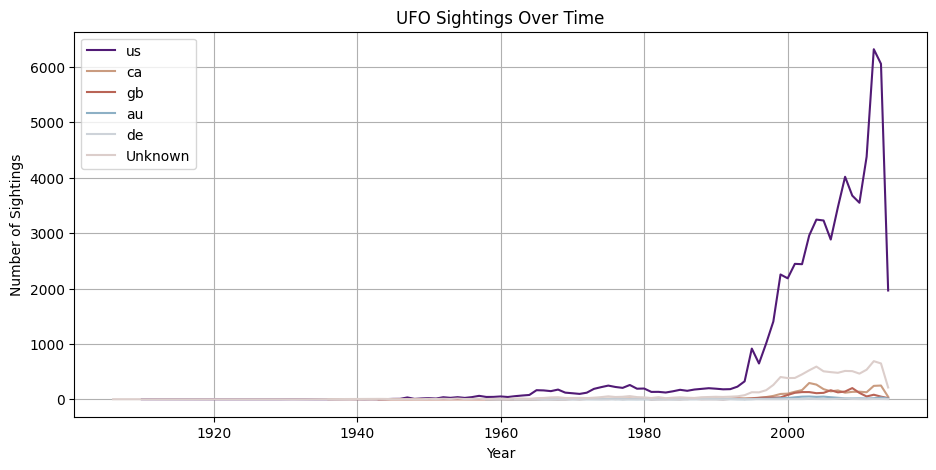

In [25]:
countries = ['us', 'ca', 'gb', 'au', 'de', 'Unknown'] 
colours =  ['#511a75', '#ca9c80', '#b96456', '#8db0c5', '#ced3d9', '#dccecb' ] 

plt.figure(figsize = (11, 5)) 

# Plot line graphs for each country and UFO sightings
for i in range(len(countries)):
    ufo_country = ufo_data[ufo_data['country'] == countries[i]]
    ufo_per_year_country = ufo_country['datetime'].dt.year.value_counts().sort_index()
    sns.lineplot(x = ufo_per_year_country.index, y = ufo_per_year_country.values, label = countries[i], color = colours[i])

plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings Over Time')
plt.legend()

plt.show() 

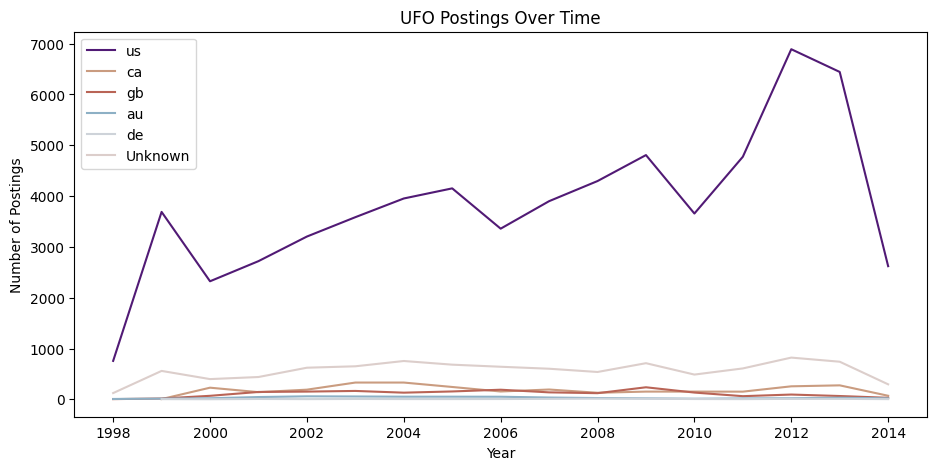

In [26]:
# Plot line graphs for each country and date posted 
plt.figure(figsize = (11, 5)) 
for i in range(len(countries)):
    ufo_country = ufo_data[ufo_data['country'] == countries[i]]
    ufo_per_year_country = ufo_country['date posted'].dt.year.value_counts().sort_index()
    sns.lineplot(x = ufo_per_year_country.index, y = ufo_per_year_country.values, label = countries[i], color = colours[i])
    
plt.xlabel('Year')
plt.ylabel('Number of Postings')
plt.title('UFO Postings Over Time')
plt.legend()

plt.show() 

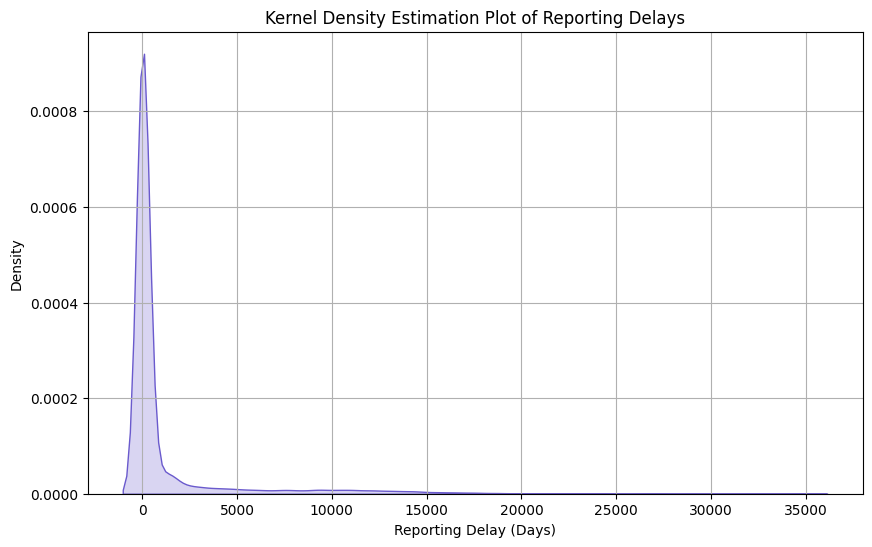

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=ufo_data, x='reporting delay', color='slateblue', fill=True)
plt.title('Kernel Density Estimation Plot of Reporting Delays')
plt.xlabel('Reporting Delay (Days)')
plt.grid(True)
plt.show()

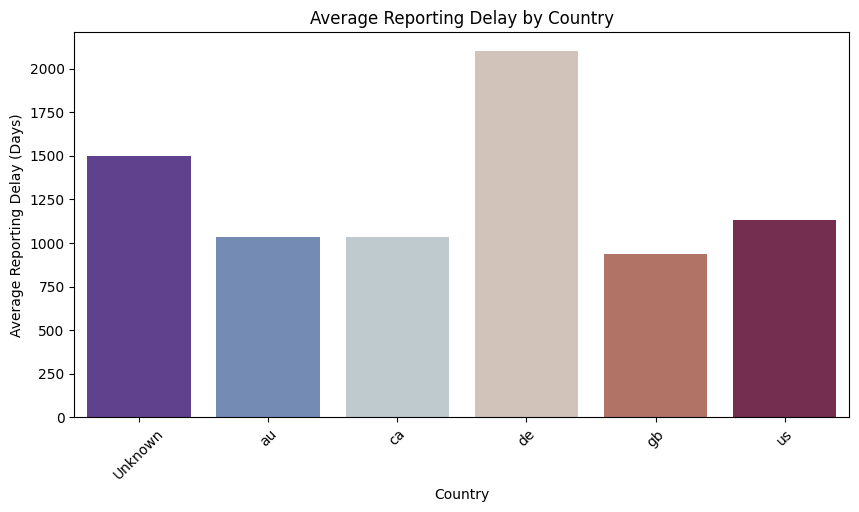

In [29]:
country_reporting_delay = ufo_data.groupby('country')['reporting delay'].mean().reset_index()

# Bar plot for averagr reporting delay by country
plt.figure(figsize = (10, 5))
sns.barplot(data = country_reporting_delay, x = 'country', y = 'reporting delay', palette = 'twilight_shifted')
plt.title('Average Reporting Delay by Country')
plt.xlabel('Country')
plt.ylabel('Average Reporting Delay (Days)')
plt.xticks(rotation = 45)

plt.show()

In [32]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

def plot_ufo_heatmap(xlim, ylim, title): 
    '''This function plots a heatmap of UFO sightings on a world map.
    The function calculates the density of UFO sightings using Gaussian Kernel Density Estimation (KDE)

    :param xlim: A tuple containing the lower and upper bounds of the longitude axis.
    :param ylim: A tuple containing the lower and upper bounds of the latitude axis.
    :param title: The title of the heatmap plot.
    :return: none
    '''
    fig, ax = plt.subplots(figsize = (13, 10))
    worldmap.plot(color = "darkgrey", ax = ax, edgecolor = 'none')
    xy = np.vstack([ufo_data['longitude'], ufo_data['latitude']])
    z = gaussian_kde(xy)(xy)

    idx = z.argsort()
    x, y, z = ufo_data['longitude'][idx], ufo_data['latitude'][idx], z[idx]

    scatter = ax.scatter(x, y, c = z, s = 1, cmap = "BuPu_r")

    cbar = plt.colorbar(scatter, ax = ax, orientation = 'horizontal', pad = 0.05)
    cbar.set_label('Density')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
    plt.show()

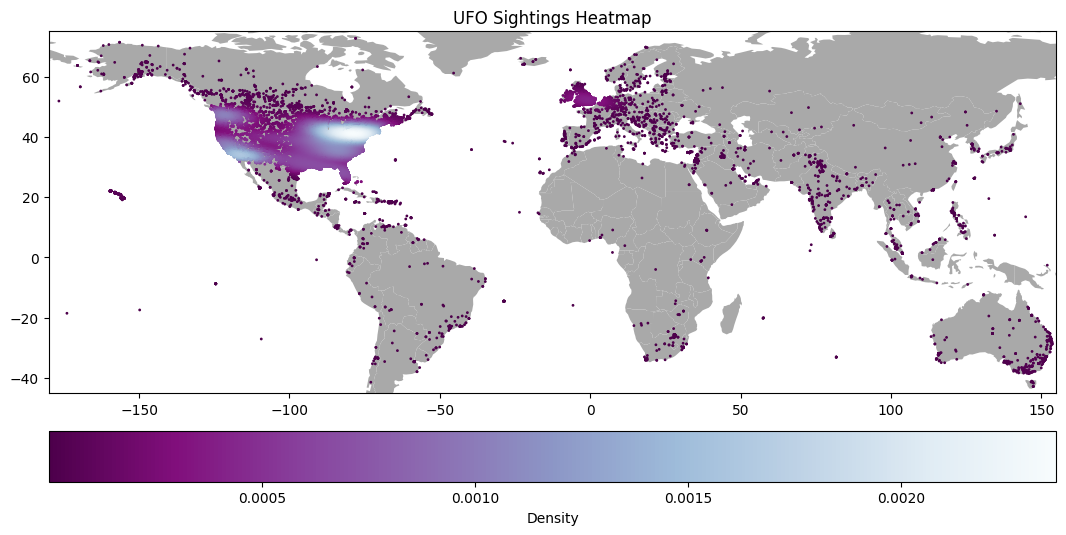

In [33]:
plot_ufo_heatmap([-180, 155], [-45, 75], "UFO Sightings Heatmap")

In [34]:
def plot_clusters(db, xlim, ylim):
    '''This function plots the clusters of UFO sightings on a world map.
    The function calculates the clusters of UFO sightings using the K means clustering algorithm.

    :param db: A pandas DataFrame containing 'latitude' and 'longitude' columns.
    :param xlim: A tuple containing the lower and upper bounds of the longitude axis.
    :param ylim: A tuple containing the lower and upper bounds of the latitude axis.
    :return: none
    '''
    coordinates = db[['longitude', 'latitude']].dropna()
    num_clusters = 200
    
    # Initialize and fit KMeans clustering
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
    kmeans.fit(coordinates)

    coordinates['cluster'] = kmeans.labels_

    fig, ax = plt.subplots(figsize = (13, 10))
    worldmap.plot(color="darkgrey", ax = ax, edgecolor = 'none')

    # Define colors for clusters
    cluster_colors = plt.cm.twilight.colors[:num_clusters]  # Use tab20 colormap for colors
    
    # Plot each cluster
    for cluster in range(num_clusters):
        cluster_data = coordinates[coordinates['cluster'] == cluster]
        color = cluster_colors[cluster % len(cluster_colors)]
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], s = 1, color = color)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("UFO Sightings Clusters")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

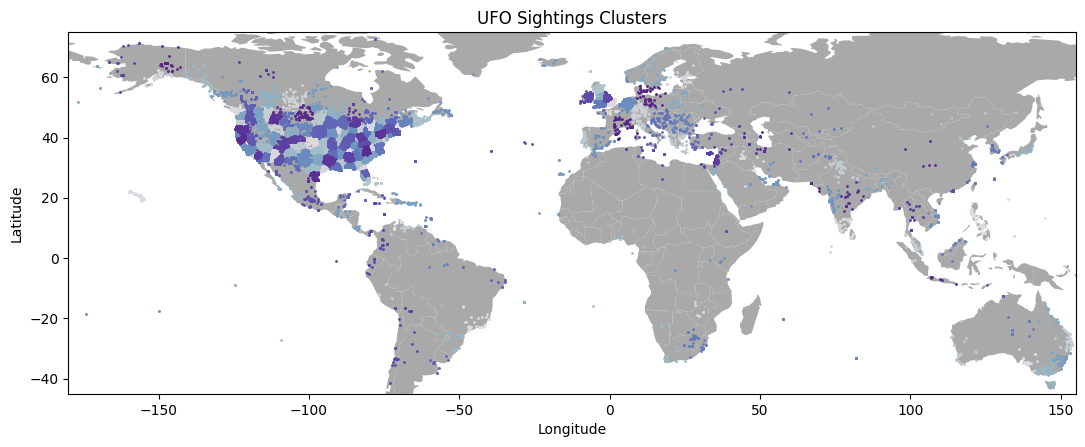

In [35]:
plot_clusters(ufo_data, [-180, 155], [-45, 75])

In [36]:
def plot_world_sentiment(db, xlim, ylim, size, title):
    '''This function plots a world map and overlays scatter points representing UFO sightings 
    with colors corresponding to their sentiment (Positive, Negative, or Neutral). The map 
    is zoomed to the specified longitude and latitude limits.

    :param db: A pandas DataFrame containing 'longitude', 'latitude', and 'sentiment' columns.
    :param xlim: A tuple specifying the limits for the x-axis (longitude).
    :param ylim: A tuple specifying the limits for the y-axis (latitude).
    :param size: The size of the scatter points.
    :param title: A string containing the country name to be inserted into the title for the plot.
    :return: None
    '''
    col = ['#5d1749','rosybrown', '#adc3cd']
    fig, ax = plt.subplots(figsize=(10, 8))
    worldmap.plot(color = "grey", ax = ax, edgecolor = 'none')

    # Define colors for positive and negative sentiment
    color_map = {'Positive': col[0], 'Negative': col[1], "Neutral":col[2]}

    x = db['longitude']
    y = db['latitude']
    sentiment_column = 'sentiment' 
    sentiment = db[sentiment_column]

    # Plot points with color corresponding to sentiment (positive or negative)
    for s in ['Neutral', 'Positive', 'Negative']:
        mask = sentiment == s
        ax.scatter(x[mask], y[mask], c = color_map[s], s = size, label = s)

    ax.legend(markerscale=3.)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("UFO Sentiments Across " + title + "!")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

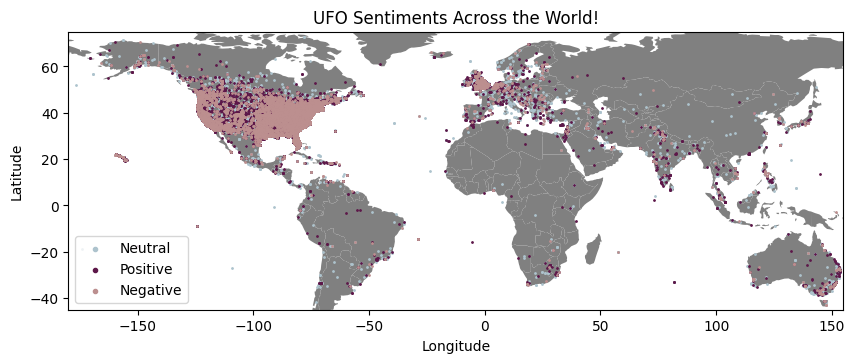

In [37]:
plot_world_sentiment(ufo_data_text, [-180, 155], [-45, 75], 1, "the World")

In [38]:
ufo_data_text.head()

,Unnamed: 0,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date posted,latitude,longitude,year,tokenized comments,tagged tokens,stemmed comments,lemmed comments,sentiment score,sentiment
0,0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700.0,45 minutes,This event took place in early fall around 194...,2004-04-27,29.883056,-97.941111,1949,"[1949-50., early, church, took, scout, sit, fa...","[(1949-50., JJ), (early, JJ), (church, NN), (t...","[1949-50., earli, church, took, scout, sit, fa...","[1949-50., early, church, took, scout, sit, fa...",0.0000,Neutral
1,1,1949-10-10 21:00:00,lackland afb,tx,Unknown,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,1949,"[lackland, ;, dime, 44, &, 90, amp, ., making,...","[(lackland, NN), (;, :), (dime, CC), (44, CD),...","[lackland, ;, dime, 44, &, 90, amp, ., make, s...","[lackland, ;, dime, 44, &, 90, amp, ., making,...",0.3612,Positive
2,2,1955-10-10 17:00:00,chester (uk/england),Unknown,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667,1955,"[green/orange, #, circular, disc, chester, eng...","[(green/orange, NN), (#, #), (circular, JJ), (...","[green/orang, #, circular, disc, chester, engl...","[green/orange, #, circular, disc, chester, eng...",0.0000,Neutral
3,3,1956-10-10 21:00:00,edna,tx,us,circle,20.0,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.978333,-96.645833,1956,"[..., leaving, older, 44, &, edna, took, diffe...","[(..., :), (leaving, VBG), (older, JJR), (44, ...","[..., leav, older, 44, &, edna, took, differ, ...","[..., leaving, old, 44, &, edna, took, differe...",0.0000,Neutral
4,4,1960-10-10 20:00:00,kaneohe,hi,us,light,900.0,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.418056,-157.803611,1960,"[aircraft, marine, 50, exercise, ;, 44, &, fly...","[(aircraft, NN), (marine, NN), (50, CD), (exer...","[aircraft, marin, 50, exercis, ;, 44, &, fli, ...","[aircraft, marine, 50, exercise, ;, 44, &, fly...",0.4019,Positive


In [39]:
ufo_data_text['concatenated'] = ufo_data_text['tokenized comments'].apply(lambda x: ' '.join(map(str, x)))
ufo_data_text['concatenated'][:5]

0    1949-50. early church took scout sit fall plac...
1    lackland ; dime 44 & 90 amp . making sky racin...
2    green/orange # circular disc chester england 44 &
3    ... leaving older 44 & edna took different the...
4    aircraft marine 50 exercise ; 44 & flying clea...
Name: concatenated, dtype: object

In [40]:
ufo_data_text['concatenated'] = ufo_data_text['concatenated'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
ufo_data_text['concatenated'][:5]

0     early church took scout sit fall place boy ar...
1    lackland  dime    amp  making sky racing light...
2         greenorange  circular disc chester england  
3     leaving older   edna took different theater t...
4    aircraft marine  exercise    flying clean   lt...
Name: concatenated, dtype: object

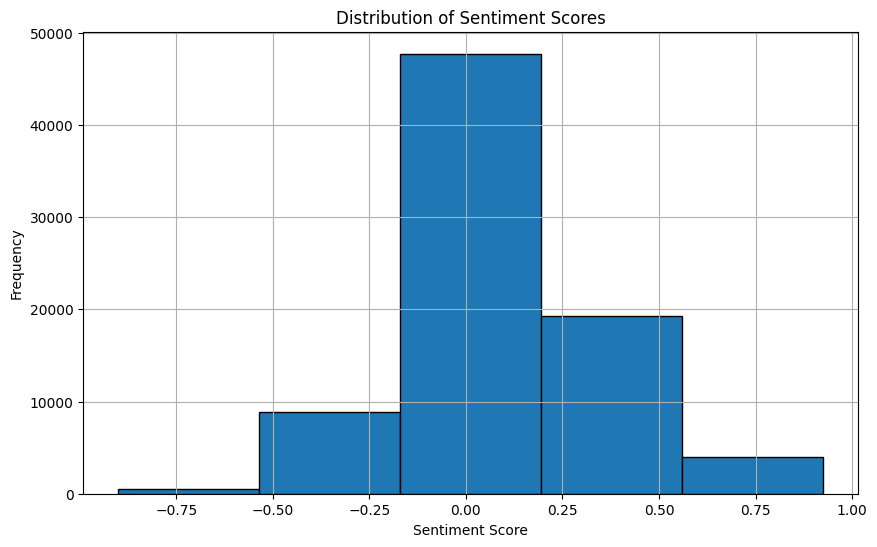

In [42]:
# Plot the distribution of numeric values in 'sentiment_score' column
plt.figure(figsize=(10, 6))
plt.hist(ufo_data_text['sentiment score'], bins=5, edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

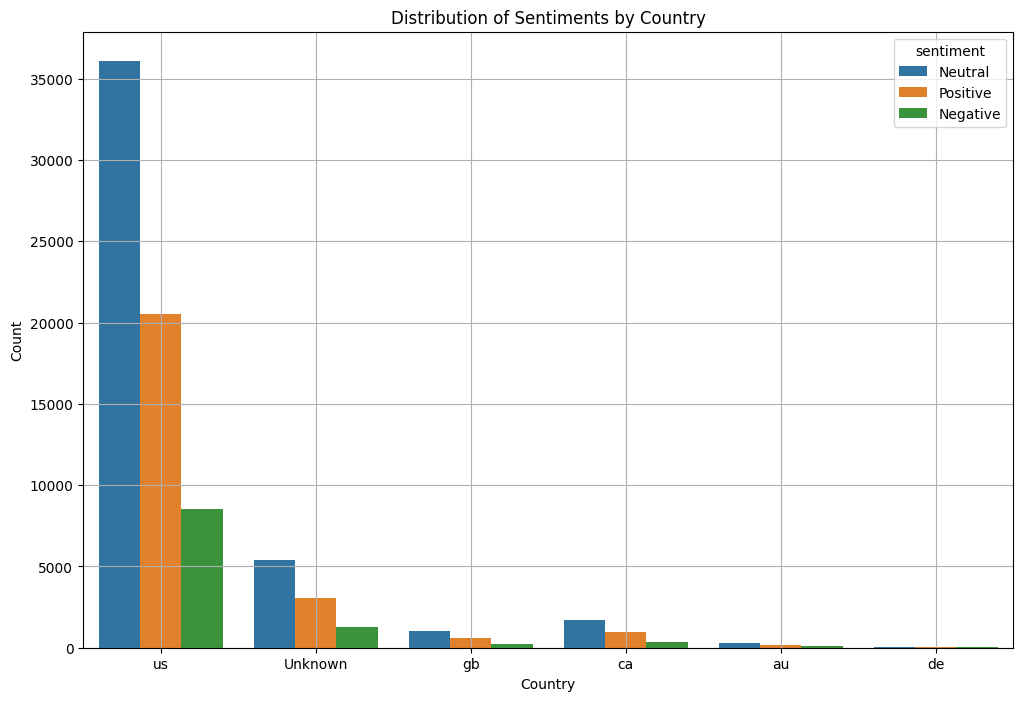

In [44]:
# Plot the distribution of sentiments for each country
plt.figure(figsize=(12, 8))
sns.countplot(x='country', hue='sentiment', data=ufo_data_text)
plt.title('Distribution of Sentiments by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.grid(True)
plt.show()


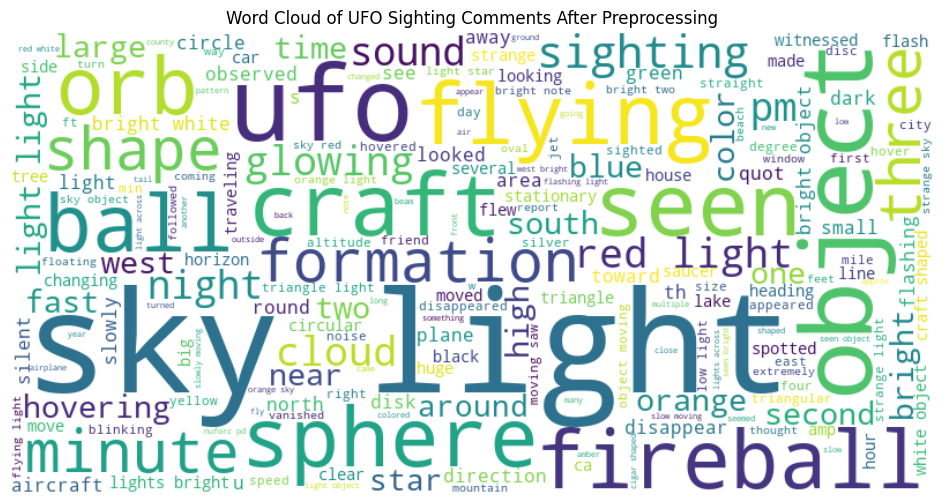

In [45]:
from wordcloud import WordCloud

# Concatenate all comments into a single string
comments_text = ' '.join(ufo_data_text['concatenated'].dropna().tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comments_text)

# Display the interactive word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of UFO Sighting Comments After Preprocessing')
plt.show()

# Find Similarities and Clusters between Comments

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [48]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(ufo_data_text['concatenated'].dropna().tolist())

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X)

print("Cluster assignments:", kmeans.labels_)

Cluster assignments: [0 9 0 ... 5 0 9]


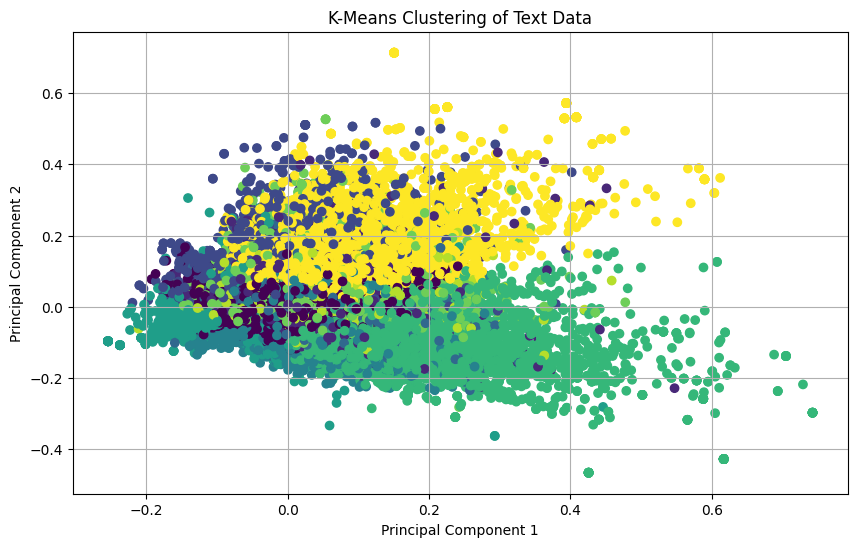

In [51]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering of Text Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [52]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

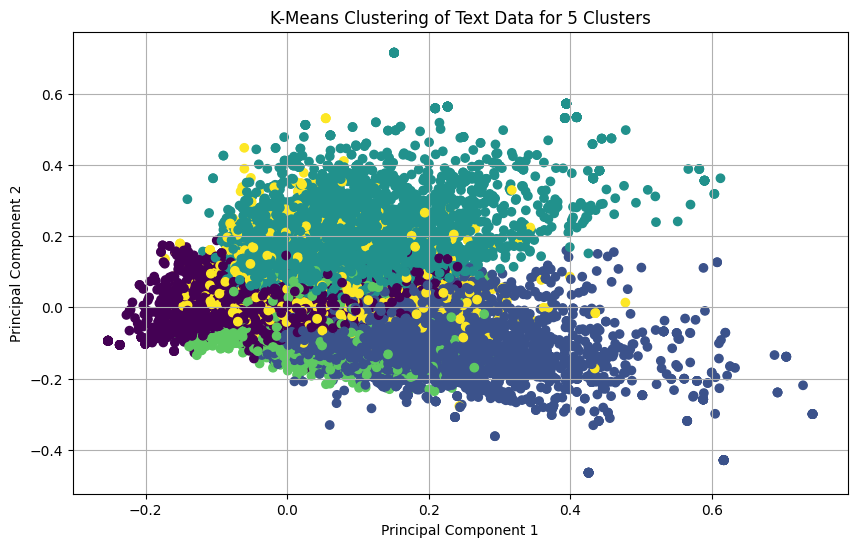

In [53]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering of Text Data for 5 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [54]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

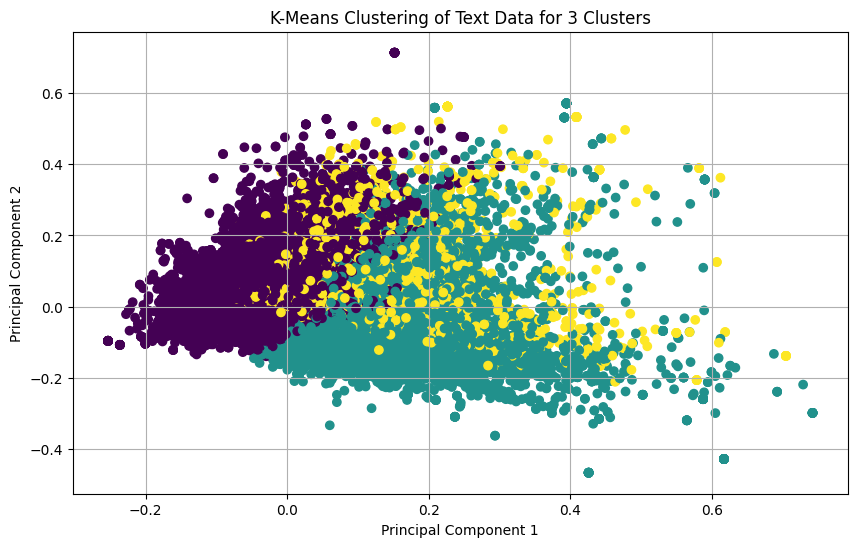

In [55]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('K-Means Clustering of Text Data for 3 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()